# Introduction

This notebook contains the full pipeline for our submissions to the 2018 VarDial Evaluation Campaign, in particular to the shared task for Discriminating between Dutch and Flemish in subtitles (DFS). We are participating only in the closed training track. See [the official page](http://alt.qcri.org/vardial2018/index.php?id=campaign) for more info.

Running the whole stack takes a really long time, especially tuning the parameters for the models, the stacks and blends. There is a cache mechanism in place, so you don't have run it all yourself.

In this notebook we run pipelines for the following features, or any combination thereof: word $n$-grams, character $n$-grams, [part of speech $n$-grams](#pos_features), [loglikelihood of $n$-grams](#llh_features), [compression rate](#compression_features), [language models](#lm_features), [word embeddings](#embedding_features). We run most of them through multiple learners, such as xgboost, random forests, linear svc, $k$ nearest neighbours, stochastic gradient descent with multiple objectives, naive bayes, nbsvm, and others. Desperate times call for desperate measures. That's why we also [blend, stack, ensemble, #insertbuzzword](#ensemble). Especially if different learners achieve a decent score, but their results have little correlation, we expect a lot of combining the models. This is also the way to win Kaggle competitions, so yes, surely one can win this shared task this way as well. Right? (right?)

There's not much background literature involved. I mean, the reference in the [literature list](https://github.com/naiaden/lama-dsl/blob/master/literature.md) don't seem to be that surprising. It also appears to be an intrinsically hard task. As a human. I think that there's also a very low human annotater agreement if one were to test this. This would then suggest that the performance ceiling is very low (I suspect around 75%, or even less). On development data we can reach around 70% accuracy (this is not the final number), so I think we're doing okayist. But I am also absolutely clueless of the competition. They will probably outwit me in imaginary ways. That'd be nice.

So let's get this notebook running. The first couple of page scrolls are filled with the boring stuff. After that is the less boring, but still boring stuff. It's the actual learning at least.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

import ucto
import pickle

Here you can enter the parts that you want to run. The identifiers are the run names, and you can find them further
in the notebook. Use "all" to run all of them; this option overrules all other run names. Also note that it takes a
seriously large amount of time to run them all.

Most of the times we don't run the experiments from the notebook, but from the console, so we're doing a little testing and flagging here to make sure we show the proper output.

In [5]:
import json

_run = set([])
_data_mode = "test-dev" # test-dev, subset-dev, cv, test
_show_graphics = True

import sys
if __name__ == '__main__' and '__file__' in globals():
    # running in console
    _show_graphics = False
    from tqdm import tqdm as tqdm, trange as tnrange
    
    for v in sys.argv:
        if v.startswith("r:"):
            _run.add(v[2:])
        elif v == "o:subset":
            _data_mode = "subset-dev"
        elif v == "o:cv":
            _data_mode = "cv"
        elif v == "o:test":
            _data_mode = "test"
            
else:
    # running in notebook
    from tqdm import tqdm_notebook as tqdm, tnrange as tnrange
    
    #_run.add("all")
    
    _use_subset = True
    pass

def do_run(name, force=False):
    if force:
        return True
    
    if name in _run or "all" in _run:
        return True
    
#     try:
#         if name not in _run_stats:
    return False

We're not going to do that much with confusion matrices, but they are a helpful tool in determining the true and false positives, and true and false negatives. We only/all want true positives. At least I do. Wikipedia says sensitivity and specificity. But that reads like a Jane Austen novel. 

Confusion matrix, without normalization
[[1 2]
 [3 4]]


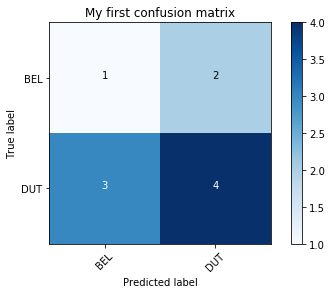

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

                      
cm = confusion_matrix(['BEL', 'BEL', 'DUT', 'DUT', 'BEL', 'DUT', 'DUT', 'DUT', 'DUT', 'DUT'],  # golden truth
                      ['BEL', 'DUT', 'DUT', 'BEL', 'DUT', 'DUT', 'BEL', 'BEL', 'DUT', 'DUT'])  # our predictions

labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(["BEL", "DUT"])

if _show_graphics:
    plt.figure()
    plot_confusion_matrix(cm, classes=labelEncoder.classes_, title="My first confusion matrix")

So, for this example, we assume that in this binary classification task we have to predict whether it's a Flemish subtitle or not. That means that Flemish is the positive class, and Netherlandic the negative class. (I obviously don't agree, but since I'm also connected to the KU Leuven, I can live with this.) Then if we properly classified the Flemish subtitle as a Flemish subtitle, it's a true positive. In this case we found 1. On the other hand we can also correctly guess that a negative example is indeed a Netherlandic subtitle. That's a true negative, and we've found 4 of them. The other two classes are confusion, be it a Flemish subtitle confused for a Netherlandic subtitle (2 out of 10 cases; false positives), or Netherlandic subtitles confused as Flemish subtitles (3 out of 10 cases; false negatives). 

We want to keep track of the runs, especially the best run of a series, its output and its parameters. To this end we have a little structure here to keep them all in one place. You have to call the functions in the order as they are defined. First you register the run with a unique name (or rather, all runs with the same name have their results merged), then you can update its statistics, and at any point you can ask for a summary of the run. One of the feats is that it will show one of those fancy confusion matrices for you. The last function is summarise_all. This one presents you with a nice goodnight story. Yes. It'll make you yawn and fall asleep. Impressed though, you will fall asleep impressed by the performance.

In [13]:
_run_stats = {}

import os.path
def register_run(name, description, params):
    if name not in _run_stats:
        # if can be loaded from file
        if os.path.exists('cache/' + name + '.json'):
            with open('cache/' + name + '.json', 'r') as f:
                run_object = json.load(f)
                _run_stats[name] = {}
                _run_stats[name]['description'] = run_object['description']
#                 _run_stats[name]['params'] = run_object['params']
                _run_stats[name]['best'] = run_object['best']
                _run_stats[name]['best_predictions'] = np.array(run_object['best_predictions'])
#                 print(np.matrix(run_object['best_predictions']))
                _run_stats[name]['orig_predictions'] = np.array(run_object['orig_predictions'])
                _run_stats[name]['history'] = run_object['history']
        else:
            _run_stats[name] = {}
            _run_stats[name]['description'] = description
#             _run_stats[name]['params'] = {}
#             for param in params:
#                 _run_stats[name]['params'][param] = ''

            _run_stats[name]['best'] = 0
            _run_stats[name]['best_predictions'] = []
            _run_stats[name]['orig_predictions'] = []
            _run_stats[name]['history'] = []

def update_stats(name, y_test, y_pred, params):
    if y_pred:
        accuracy = accuracy_score(y_test, y_pred)
        _run_stats[name]['history'].append(accuracy)
        if accuracy > _run_stats[name]['best']:
            _run_stats[name]['best'] = accuracy
    #         for param in params:
    #             _run_stats[name]['params'][param] = params[param]
            _run_stats[name]['best_predictions'] = y_pred
            _run_stats[name]['orig_predictions'] = y_test

            with open("cache/" + name + ".json", 'w') as f:
                json.dump({'best_predictions': _run_stats[name]['best_predictions'].tolist(),
                           'description': _run_stats[name]['description'],
    #                        'params': _run_stats[name]['params'],
                           'history': _run_stats[name]['history'],
                           'orig_predictions': _run_stats[name]['orig_predictions'].tolist(),
                           'best': _run_stats[name]['best']
                          }, f)
    #         with open('cache/' + name + '.pickle', 'w') as f:
    #             pickle.dump(_run_stats[name], f, pickle.HIGHEST_PROTOCOL)

        
def summarise_run(name):
    if name not in _run_stats:
        print("Name %s is not registrered." % (name))
        return
    
    print("Model:    \n\t%s" % (name))
    #print("Settings: \n\t%s" % (_run_stats[name]['params']))
    print("Accuracy: \n\t%s" % (_run_stats[name]['best']))

    cm = confusion_matrix(_run_stats[name]['orig_predictions'], _run_stats[name]['best_predictions'])
    
    if _show_graphics:
        plt.figure()
        plot_confusion_matrix(cm, classes=labelEncoder.classes_, title=name)# + " " + str(_run_stats[name]['params']))
        plt.show()
    else:
        print(cm)       

def summarise_all():
    for name in _run_stats.keys():
        summarise_run(name)
        print()



# Data preprocessing

We read the file with [ucto](https://github.com/proycon/python-ucto) and tokenise it according to its default Dutch tokenisation scheme, which is rule-based
and definitely better than a plain whitespace tokeniser from sklearn. Afterwards we concatenate the tokens back to a 
whitespace seperated line, which can then be normally processed with sklearn's tokenisers.

In [8]:
ucto_config = "tokconfig-nld"
tokeniser = ucto.Tokenizer(ucto_config, sentenceperlineinput=True, sentencedetection=False, paragraphdetection=False)

def read_data(file):
    text = {}
    with open(file) as f:
        for line in tqdm(f):
            sentence, language = line.strip().split("\t")
            tokeniser.process(sentence)

            if language not in text:
                text[language] = []

            current_line = []
            for token in tokeniser:
                current_line.append(str(token))
                if token.isendofsentence():
                    #print(current_line)
                    text[language].append(" ".join(current_line))
                    current_line = []
    return text

If this is the first run, then we have to tokenise the text. In other cases we probably have saved a pickled version
somewhere. If not, we will tokenise the text anyway. No worries.

In [9]:
# First the development set
try:
    with open('data/dev.txt.pickle', 'rb') as f:
        _l_dev_text = pickle.load(f)
        print("Done reading development set from pickle.")
except IOError:
    _l_dev_text = read_data('data/dev.txt')
    print("Done tokenising development set.")
    with open('data/dev.txt.pickle', 'wb') as f:
        pickle.dump(_l_dev_text, f, pickle.HIGHEST_PROTOCOL)
    print("Done writing development set from pickle.")

print("development set")
print("\t LAN\t size \t avg length")
for l in _l_dev_text.keys():
    print("\t", l, "\t", len(_l_dev_text[l]), "\t", sum([len(x.split()) for x in _l_dev_text[l]])/len(_l_dev_text[l]))

# And then the training set. This takes bit more time...
try:
    with open('data/train.txt.pickle', 'rb') as f:
        _l_trn_text = pickle.load(f)
        print("Done reading training set from pickle.")
except IOError:
    _l_trn_text = read_data('data/train.txt')
    print("Done tokenising training set.")
    with open('data/train.txt.pickle', 'wb') as f:
        pickle.dump(_l_trn_text, f, pickle.HIGHEST_PROTOCOL)
    print("Done writing training set from pickle.")

print("training set")
print("\t LAN\t size \t avg length")
for l in _l_trn_text.keys():
    print("\t", l, "\t", len(_l_trn_text[l]), "\t", sum([len(x.split()) for x in _l_trn_text[l]])/len(_l_trn_text[l]))
    

Done reading development set from pickle.
development set
	 LAN	 size 	 avg length
	 BEL 	 250 	 40.456
	 DUT 	 250 	 40.088
Done reading training set from pickle.
training set
	 LAN	 size 	 avg length
	 BEL 	 150000 	 40.273626666666665
	 DUT 	 150000 	 40.37152


Now is as good a time as any to import some random stuff.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from matplotlib.legend_handler import HandlerLine2D

Here we convert the training and development material into the right shape, and make sure that we also keep track of
the labels.

In [24]:
_X_training = []
_y_training = []
for l in _l_trn_text.keys():
    for s in _l_trn_text[l]:
        _X_training.append(s)
        _y_training.append(l)
_X_training = np.array(_X_training, dtype=object)
_y_training = labelEncoder.transform(_y_training)


_X_dev = []
_y_dev = []
for l in _l_dev_text.keys():
    for s in _l_dev_text[l]:
        _X_dev.append(s)
        _y_dev.append(l)
_X_dev = np.array(_X_dev, dtype=object)
_y_dev = labelEncoder.transform(_y_dev)



One of the features that was promised to deliver mountains of gold, and other glory, such as the first place in whatever context is part of speech tags. We will generate them with [frog](https://github.com/proycon/python-frog). We're not really interested in the full tag, but more so in the head of the tag. That's why it's the only part we're keeping. It's slow. It's faster to generate them yourself than to ask me to mail you them but still. It's slooow.

In [33]:
if not os.path.exists('data/' + 'dev' + '.POS.txt') or not os.path.exists('data/' + 'train' + '.POS.txt'):
    import frog

    frog = frog.Frog(frog.FrogOptions(parser=False))

    for t in ['dev', 'train']:
        with open('data/' + t + '.POS.txt', 'w') as out:
            with open('data/' + t + '.txt', 'r') as f:
                for line in f:
                    sentence, tag = line.strip().split("\t")
                    froggo = frog.process(sentence)
                    postext = []
                    for w in froggo:
                        postext.append(w['pos'].split("(")[0])
                    out.write(" ".join(postext) + "\t" + tag + "\n")

Here we convert the part of speech training material into the same form as two cells up.

In [37]:
_X_pos_training = []
_y_pos_training = []
with open('data/train.POS.txt', 'r') as f:
    for line in f:
        sentence, tag = line.strip().split("\t")
        _X_pos_training.append(sentence)
        _y_pos_training.append(tag)
_X_pos_training = np.array(_X_pos_training)
_y_pos_training = labelEncoder.transform(_y_pos_training)

_X_pos_dev = []
_y_pos_dev = []
with open('data/dev.POS.txt', 'r') as f:
    for line in f:
        sentence, tag = line.strip().split("\t")
        _X_pos_dev.append(sentence)
        _y_pos_dev.append(tag)
_X_pos_dev = np.array(_X_pos_dev)
_y_pos_dev = labelEncoder.transform(_y_pos_dev)

Sometimes for testing whether some code words, you might want to use a subset. Use this one. Or another one. I don't
care. 

In [57]:
_data_mode = "subset-dev"

if _data_mode == "test-dev":
    X_training = _X_training
    y_training = _y_training
    X_dev = _X_dev
    y_dev = _y_dev
    
    X_pos_training = _X_pos_training
    y_pos_training = _y_pos_training
    X_pos_dev = _X_pos_dev
    y_pos_dev = _y_pos_dev
elif _data_mode == "subset-dev":
    import random
    use = random.sample(range(1, 299999), 500)
#     X_training = [_X_training[use]]
#     y_training = [_y_training[use]]
#     X_dev = [_X_dev]
#     y_dev = [_y_dev]
    
#     X_pos_training = [_X_pos_training[use]]
#     y_pos_training = [_y_pos_training[use]]
#     X_pos_dev = [_X_pos_dev]
#     y_pos_dev = [_y_pos_dev]
    X_training = _X_training[use]
    y_training = _y_training[use]
    X_dev = _X_dev
    y_dev = _y_dev
    
    X_pos_training = _X_pos_training[use]
    y_pos_training = _y_pos_training[use]
    X_pos_dev = _X_pos_dev
    y_pos_dev = _y_pos_dev
elif _data_mode == "test":
#     X_training = [np.concatenate((_X_training, _X_dev))]
#     y_training = [np.concatenate((_y_training, _y_dev))]
#     X_dev = [np.array([])]
#     y_dev = [np.array([])]
    
#     X_pos_training = [np.concatenate((_X_pos_training, _X_pos_dev))]
#     y_pos_training = [np.concatenate((_y_pos_training, _y_pos_dev))]
#     X_pos_dev = [np.array([])]
#     y_pos_dev = [np.array([])]
    X_training = np.concatenate((_X_training, _X_dev))
    y_training = np.concatenate((_y_training, _y_dev))
    X_dev = np.array([])
    y_dev = np.array([])
    
    X_pos_training = np.concatenate((_X_pos_training, _X_pos_dev))
    y_pos_training = np.concatenate((_y_pos_training, _y_pos_dev))
    X_pos_dev = np.array([])
    y_pos_dev = np.array([])
elif _data_mode == "cv":
    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    X_all = np.concatenate((_X_training, _X_dev))
    y_all = np.concatenate((_y_training, _y_dev))
    X_training = []
    X_dev = []
    y_training = []
    y_dev = []
    
    X_pos_all = np.concatenate((_X_pos_training, _X_pos_dev))
    y_pos_all = np.concatenate((_y_pos_training, _y_pos_dev))
    X_pos_training = []
    X_pos_dev = []
    y_pos_training = []
    y_pos_dev = []
    
    for train_index, test_index in kf.split(X_all):
        X_training.append(X_all[train_index])
        X_dev.append(X_all[test_index])
        y_training.append(y_all[train_index])
        y_dev.append(y_all[test_index])
        
        X_pos_training.append(X_pos_all[train_index])
        X_pos_dev.append(X_pos_all[test_index])
        y_pos_training.append(y_pos_all[train_index])
        y_pos_dev.append(y_pos_all[test_index])

# print("Summary of the training and development (test) data")
# print("\tNumber of sets:   ", len(X_training))
# print("\tNumber of examples in X_training: ", [len(x) for x in X_training])
# print("\tNumber of labels   in y_training: ", [len(x) for x in y_training])
# print("\tNumber of examples in X_dev:      ", [len(x) for x in X_dev])
# print("\tNumber of labels   in y_dev:      ", [len(x) for x in y_dev])

# Feature engineering

## Count-based features
Okay, so let's get the feature engineering started. 

In [125]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

features = {}

# On the given data

features['char_count_vect_1_8'] = {'analyser': CountVectorizer(analyzer='char', ngram_range=(1,8)),
                                   'values': {'x_tr': [], 'x_te': []},
                                   }

features['word_count_vect_1_6'] = {'analyser': CountVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"),
                                   'values': {'x_tr': [], 'x_te': []},
                                   }

features['char_tfidf_vect_1_8'] = {'analyser': TfidfVectorizer(analyzer='char', ngram_range=(1,8)),
                                   'values': {'x_tr': [], 'x_te': []},
                                   }

features['word_tfidf_vect_1_6'] = {'analyser': TfidfVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"),
                                   'values': {'x_tr': [], 'x_te': []},
                                   }

features['woch_tfidf_vect_1_8'] = {'analyser': FeatureUnion([('char', TfidfVectorizer(analyzer='char', ngram_range=(1,8))),
                                                             ('word', TfidfVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))]),
                                   'values': {'x_tr': [], 'x_te': []},
                                   }

for feature in features.keys():
    features[feature]['values']['x_tr'] = features[feature]['analyser'].fit_transform(X_training)
    features[feature]['values']['x_te'] = features[feature]['analyser'].transform(X_dev)

# On derivative data

features['pos_tfidf_vect_2_6'] = {'analyser': TfidfVectorizer(analyzer='word', ngram_range=(2,6),token_pattern=u"(?u)\\b\\w+\\b"),
                                   'values': {'x_tr': [], 'x_te': []},
                                   }
features['pos_tfidf_vect_2_6']['values']['x_tr'] = features['pos_tfidf_vect_2_6']['analyser'].fit_transform(X_pos_training)
features['pos_tfidf_vect_2_6']['values']['x_te'] = features['pos_tfidf_vect_2_6']['analyser'].transform(X_pos_dev)

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [107]:
models = {}

In [119]:
class BLA():
    def __init__(self, name, pipeline, parameters, X_training, y_training, verbose=False):
        self.name = name
        self.pipeline = pipeline
        self.parameters = parameters
        self.X_training = X_training
        self.y_training = y_training
        self.verbose = verbose
        
        self.fresh_run = not os.path.exists('models/' + self.name + '.sav')
    
    def __enter__(self):
        if self.fresh_run:
            print("fresh run")
            self.clf = GridSearchCV(self.pipeline, self.parameters, cv=kf, n_jobs=-1)
            self.clf.fit(self.X_training, self.y_training)
        else:
            print("from file")
            self.clf = joblib.load('models/' + self.name + '.sav')
        return self.clf
    
    def __exit__(self, *args):
        models[self.name] = {'score': clf.best_score_, 'estimator': clf.best_estimator_}
        
        if self.fresh_run:
            joblib.dump(clf, 'models/' + self.name + '.sav')
        
        if self.verbose:
            print("Best parameters set found with gridsearchcv:")
            print(self.clf.best_params_)
            print()
            means = self.clf.cv_results_['mean_test_score']
            stds = self.clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, self.clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))

In [88]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.ensemble import RandomForestClassifier

with BLA('randomforest_wordchar_count',
          Pipeline([('union', FeatureUnion([('char', CountVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', CountVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
                    ('kbest', SelectKBest()), 
                    ('rfc', RandomForestClassifier(oob_score = True))]),
          {'kbest__k': [10,100, 1000, 10000, 100000, 'all'], 
                  'rfc__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                  'rfc__n_estimators': [10, 50, 100, 150, 200, 250],
                  'rfc__min_samples_leaf': [1, 5, 10, 25, 50, 75, 100, 250],
                  'union__word__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 8)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

In [ ]:
from sklearn.naive_bayes import MultinomialNB

with BLA('multinomialnb_wordchar_count',
          Pipeline([('union', FeatureUnion([('char', CountVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', CountVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
                    ('kbest', SelectKBest()), 
                    ('mnb', MultinomialNB())]),
          {'kbest__k': [100, 1000, 10000, 1000000, 'all'], 
                  'mnb__alpha': [0, 0.00001, 0.0001, 0.001, 0.05, 0.5, 1.0, 1.5, 2.5],
                  'union__word__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 8)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

In [ ]:
from sklearn.linear_model import SGDClassifier

with BLA('sgdhinge_wordchar_count',
          Pipeline([('union', FeatureUnion([('char', CountVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', CountVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
                    ('kbest', SelectKBest()), 
                    ('sgd', SGDClassifier(shuffle=True))]),
          {'kbest__k': [100, 1000, 10000, 1000000, 'all'], 
                  'sgd__alpha': 10.0**-np.arange(1,9),
                  'union__word__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 8)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

In [ ]:
from sklearn.ensemble import RandomForestClassifier

with BLA('randomforest_wordchar_tfidf',
          Pipeline([('union', FeatureUnion([('char', TfidfVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', TfidfVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
                    ('kbest', SelectKBest()), 
                    ('rfc', RandomForestClassifier(oob_score = True))]),
          {'kbest__k': [10,100, 1000, 10000, 100000, 'all'], 
                  'rfc__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
                  'rfc__n_estimators': [10, 50, 100, 150, 200, 250],
                  'rfc__min_samples_leaf': [1, 5, 10, 25, 50, 75, 100, 250],
                  'union__word__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 8)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

In [ ]:
from sklearn.naive_bayes import MultinomialNB

with BLA('multinomialnb_wordchar_tfidf',
          Pipeline([('union', FeatureUnion([('char', TfidfVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', TfidfVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
                    ('kbest', SelectKBest()), 
                    ('mnb', MultinomialNB())]),
          {'kbest__k': [100, 1000, 10000, 1000000, 'all'], 
                  'mnb__alpha': [0, 0.00001, 0.0001, 0.001, 0.05, 0.5, 1.0, 1.5, 2.5],
                  'union__word__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 8)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

In [ ]:
from sklearn.linear_model import SGDClassifier

with BLA('sgdhinge_wordchar_tfidf',
          Pipeline([('union', FeatureUnion([('char', TfidfVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', TfidfVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('scaler', StandardScaler(copy=True, with_mean=False, with_std=True)),
                    ('kbest', SelectKBest()), 
                    ('sgd', SGDClassifier(shuffle=True))]),
          {'kbest__k': [100, 1000, 10000, 1000000, 'all'], 
                  'sgd__alpha': 10.0**-np.arange(1,9),
                  'union__word__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 8)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

In [127]:
from sklearn.ensemble import RandomForestClassifier

with BLA('randomforest_char_count_vect_1_8',
          Pipeline([('union', FeatureUnion([('char', TfidfVectorizer(analyzer='char', ngram_range=(1,8))),
                                            ('word', TfidfVectorizer(analyzer='word', ngram_range=(1,6),token_pattern=u"(?u)\\b\\w+\\b"))])),
                    ('kbest', SelectKBest()), 
                    ('rfc', RandomForestClassifier(oob_score = True))]),
          {'kbest__k': [10,100], 
                  'rfc__max_features': [0.2, 1.0],
                  'rfc__n_estimators': [10, 50],
                  'rfc__min_samples_leaf': [50, 100, 250],
                  'union__char__ngram_range': [(x,y) for x in range(1,4) for y in range(x, 6)]
                  },
          X_training,
          y_training) as b:
    y_t, y_p = y_dev, b.best_estimator_.predict(X_dev)
    print(classification_report(y_t, y_p, target_names=labelEncoder.classes_))
    print(confusion_matrix(y_t, y_p))
    print("accuracy: ", accuracy_score(y_t, y_p))
    

from file


ValueError: could not convert string to float: 'Deze enorme vrachtschepen zijn erg afhankelijk van hun schroef . Ze zijn soms drie verdiepingen hoog en hun bouw vereist veel kennis . Hoe doen ze dat ? Varen met een 157 . 000 ton zwaar en 397 meter lang containerschip als de Estelle M rsk , is geen eenvoudige opgave .'

## Loglikelihood-based features

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix, lil_matrix

class LLHbasedBinaryVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, count=1000):
        self.llh_1000 = []
        with open('data/DUT_BEL.t5m1l6.llh_t', 'r') as f:
            for n, line in enumerate(f):
                self.llh_1000.append(line.split("\t")[0])
                if count != "all" and n >= count:
                    break
    
    def llh_binary_countvectorizer(self, line):
        values = []
        for k in self.llh_1000:
            values.append(1*(k in line))
        return lil_matrix(values)
    
    def transform(self, df, y=None):
        result = csr_matrix((len(df),len(self.llh_1000)))
        for r, l in enumerate(df):
            result[r,:] = self.llh_binary_countvectorizer(l)
        return result
    
    def fit(self, df, y=None):
        return self

In [ ]:
features['llh_vect_100k'] = {'analyser': LLHbasedBinaryVectorizer(count=100000),
                             'values': {'x_tr': [], 'y_tr': []},
                            }
for kfold in range(len(X_training)):
    features['llh_vect_100k']['x_tr'].append(features['llh_vect_100k']['analyser'].fit_transform(X_training[kfold]))
    features['llh_vect_100k']['y_tr'].append(features['llh_vect_100k']['analyser'].fit_transform(X_dev[kfold]))

## Embedding features
No experiment these days is complete without using embeddings. It's fancier than the multilayer perceptron that we're using. [Fasttext](https://github.com/facebookresearch/fastText) seems to work quite well actually. "Thank you Facebook." There, I said it.

In [ ]:
import fasttext

from sklearn.base import BaseEstimator, ClassifierMixin

class FasttextFeatures(BaseEstimator, ClassifierMixin):
    def __init__(self, count=1000):

        
    def transform(self, df, y=None):
        return hoi
    
    def fit(self, df, y=None):
        
        
    
    def llh_binary_countvectorizer(self, line):
        values = []
        for k in self.llh_1000:
            values.append(1*(k in line))
        return lil_matrix(values)
    
    def transform(self, df, y=None):
        result = csr_matrix((len(df),len(self.llh_1000)))
        for r, l in enumerate(df):
            result[r,:] = self.llh_binary_countvectorizer(l)
        return result
    
    def fit(self, df, y=None):
        return self